# Pierwsze komórki są testami, późniejsze rezultaty są niżej

In [14]:
import os
import fiona
import rasterio
import rasterio.mask
import numpy as np


name = 'Swiebodzin'
path = "/media/piotr/824F-8A2A/Swiebodzin/"

shapes = fiona.open(os.path.join(path, 'obszar_'+name.lower()+'.shp'))



In [15]:
shape = shapes[0]['geometry']['coordinates'][0]

In [16]:
x = np.array([a[0] for a in shape])
y = np.array([a[1] for a in shape])
x_mean = x.mean()
y_mean = y.mean()
x_max = np.abs(x-x_mean).max()
y_max = np.abs(y-y_mean).max()


39699
8876
37216
11196
Window(col_off=8876, row_off=37216, width=2320, height=2483)


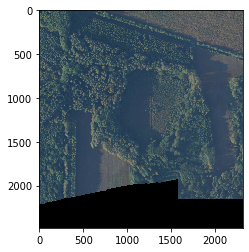

In [18]:
import matplotlib.pyplot as plt

with rasterio.open(os.path.join(path,'RGB_'+name+'.tif')) as tif_handler:
    row_start, col_start = tif_handler.index(x_mean-x_max, y_mean-y_max)
    row_stop, col_stop = tif_handler.index(x_mean+x_max, y_mean+y_max)
    print(row_start)
    print(col_start)
    print(row_stop)
    print(col_stop)
    win = rasterio.windows.Window.from_slices((row_stop, row_start), (col_start, col_stop))
    
    print(win)
    
    img = np.moveaxis(np.stack([tif_handler.read(i+1, window=win) for i in range(3)]),0,-1)
    plt.imshow(img)

In [19]:
img.shape

(2483, 2320, 3)

In [20]:
from osgeo import gdal

driver = gdal.GetDriverByName('GTiff')
filename = os.path.join(path,'RGB_'+name+'.tif')


def get_pixel_based_on_lon_lat(tif, points_list):
    band = tif.GetRasterBand(1)

    cols = tif.RasterXSize
    rows = tif.RasterYSize

    transform = tif.GetGeoTransform()

    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    data = band.ReadAsArray(0, 0, cols, rows)

    rows = []
    cols = []
    for point in points_list:
        cols.append(int((point[0] - xOrigin) / pixelWidth))
        rows.append(int((yOrigin - point[1]) / pixelHeight))

    return cols, rows



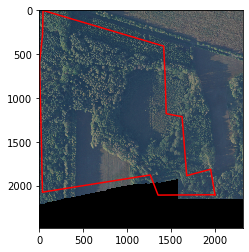

In [21]:

joint = [tif_handler.index(l[0], l[1]) for l in shape]
x = np.array([l[0] for l in joint])
x = x - x.min()
y = np.array([l[1] for l in joint])
y = y - y.min()
plt.imshow(img)
plt.plot(y,x, color='r')

In [23]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from shapely.geometry import shape
import matplotlib.pyplot as plt
import os
import fiona
import rasterio
import rasterio.mask
import numpy as np
import cv2


def initiate_geoms(shp):
    if shp['type'] == 'Polygon':
        return shp['coordinates']
    else:
        return [poly[0] for poly in shp['coordinates']]

    
    
name = 'Swiebodzin'
path = "/media/piotr/824F-8A2A/Swiebodzin/"

shapes = fiona.open(os.path.join(path,'obszar_'+name.lower()+'.shp'))



In [24]:
shapes[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('id_ob', 721),
              ('id_adres', 1420016057),
              ('adr_les', '14-20-2-13-359A  -    -'),
              ('pow', 39.53),
              ('oddz', '359A')]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(246787.5765571584, 491391.4736039958),
    (246645.07730671292, 491390.5542539929),
    (246625.5176858866, 491441.0832744609),
    (246359.832836329, 491398.7040960041),
    (246355.2241989116, 491397.6825938961),
    (246352.88, 491512.22),
    (246351.82, 491557.15),
    (246351.5, 491570.66),
    (246351.35, 491577.03),
    (246350.72999999998, 491603.22),
    (246348.44, 491699.63),
    (246347.97, 491719.58),
    (246347.91999999998, 491721.6),
    (246350.28, 491743.85),
    (246355.41, 491792.13),
    (246356.66, 491853.5),
    (246658.95, 491763.85),
    (246661.75, 491707.23),
    (246662.32, 491695.79),
    (246662.75, 491681.41),
    (246665.33000000002, 491594.59),
    (246672.53999999998, 4

In [25]:
@interact(i=(0,len(shapes)-1,1))
def plot_shape(i):
    single_shape = shapes[i]
    shp = initiate_geoms(single_shape['geometry'])
    print(single_shape['properties'])
    with rasterio.open(os.path.join(path,'RGB_'+name+'.tif')) as tif_handler:
        x = np.array([a[0] for poly in shp for a in poly])
        y = np.array([a[1] for poly in shp for a in poly])
        row_start, col_start = tif_handler.index(x.min(), y.min())
        row_stop, col_stop = tif_handler.index(x.max(), y.max())
        win = rasterio.windows.Window.from_slices((row_stop, row_start), (col_start, col_stop))
        img = np.stack([tif_handler.read(i+1, window=win) for i in range(3)])
        mask = np.zeros(img.shape[1:],dtype=np.uint8)
        for poly in shp:
            joint = [tif_handler.index(l[0], l[1]) for l in poly]
            joint = np.array([[[l[1]-col_start, l[0]-row_stop] for l in joint]], dtype=np.int32)
            cv2.fillPoly(mask, pts =[joint], color= 255)
        masked = cv2.bitwise_and(img,img,mask = np.stack([mask,mask,mask]))
        plt.imshow(np.moveaxis(masked,0,-1))
        

interactive(children=(IntSlider(value=110, description='i', max=220), Output()), _dom_classes=('widget-interac…

# Segmentacja chorych drzew i zliczanie

In [1]:
from forest_iterator_class import ForestIterator
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from shapely.geometry import shape
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.mask
import numpy as np
import cv2


def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


name = 'Swiebodzin'
path = "/media/piotr/824F-8A2A/Swiebodzin/"

shape_path = os.path.join(path,'obszar_'+name.lower()+'.shp')
shapes = fiona.open(shape_path)
rgb_path = os.path.join(path,'RGB_'+name+'.tif')
nir_path = os.path.join(path,'NIR_'+name+'.tif')
it = ForestIterator(rgb_path,shape_path,nir_path)

In [5]:
it[163]

{'rgb': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'ndvi': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'description': OrderedDict([('id_ob', 211),


## Segmentacja chorych drzew

In [2]:
#163
@interact(i=(0,len(shapes)-1,1))
def plot_shape(i=163):
    data = it[i]
    rgb = data['rgb']
    nir = data['ndvi']
    kernel = np.ones((9,9),np.uint8)
    
    #NDVI Thresholding
    ret, mask_nir = cv2.threshold(nir, 0.20, 1, cv2.THRESH_BINARY_INV)
    mask_nir = cv2.morphologyEx(mask_nir, cv2.MORPH_OPEN, kernel)
    mask_nir = cv2.morphologyEx(mask_nir, cv2.MORPH_CLOSE, kernel)
    mask_nir = np.uint8(mask_nir)
    rgb_mask_nir = np.stack([mask_nir,mask_nir,mask_nir])
    masked_rgb = cv2.bitwise_and(rgb,rgb,mask=rgb_mask_nir)
    
    #Red Thresholding
    ret, mask_r = cv2.threshold(masked_rgb[0,:,:],80 ,255 ,cv2.THRESH_BINARY)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_OPEN, kernel)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_CLOSE, kernel)
    mask_r = np.uint8(mask_r)
    rgb_mask_r = np.stack([mask_r,mask_r,mask_r])
    masked_rgb = cv2.bitwise_and(masked_rgb,masked_rgb,mask=rgb_mask_r)
    
    #Printing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    ax1.imshow(np.moveaxis(data['rgb'],0,-1))
    ax2.imshow(nir, cmap='gray')
    ax3.imshow(np.moveaxis(masked_rgb,0,-1))
    ax4.imshow(cv2.bitwise_and(mask_nir,mask_r))

interactive(children=(IntSlider(value=163, description='i', max=220), Output()), _dom_classes=('widget-interac…

## K-means terenu

In [31]:
from skimage.color import label2rgb
from sklearn.cluster import KMeans

rgb = np.moveaxis(it[163]['rgb'],0,-1)
lab_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
a_flatten = np.array(a_channel).flatten()
b_flatten = np.array(b_channel).flatten()
stacked = np.moveaxis(np.stack([a_flatten, b_flatten]),0,-1)
    
kmeans = KMeans(n_clusters=7, random_state=0).fit(stacked)


MemoryError: Unable to allocate 282. MiB for an array with shape (3, 12340226) and data type float64

In [ ]:
@interact(i=(0,len(shapes)-1,1))
def plot_shape(i=163):
    data = it[i]
    rgb = data['rgb']
    nir = data['nir']
    kernel = np.ones((9,9),np.uint8)
    
    #K-means data preparation
    rgb = np.moveaxis(rgb,0,-1)
    lab_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2LAB)
    l_channel,a_channel,b_channel = cv2.split(lab_image)
    a_flatten = np.array(a_channel).flatten()
    b_flatten = np.array(b_channel).flatten()
    stacked = np.moveaxis(np.stack([a_flatten, b_flatten]),0,-1)
    
    mask = np.reshape(kmeans.predict(stacked),(a_channel.shape[0], a_channel.shape[1]))
    
    segmented_image = label2rgb(mask)
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    ax1.imshow(rgb)
    ax2.imshow(segmented_image, cmap="gray")

interactive(children=(IntSlider(value=163, description='i', max=220), Output()), _dom_classes=('widget-interac…

## Zliczanie drzew

In [20]:
@interact(patch=(0,len(it)-1,1),x=(0,3000,10),y=(0,3000,10),window_size=(100,1000,10))
def plot_shape(patch=163, x=1660, y=1020, window_size=360):
    data = it[patch]
    rgb = data['rgb']
    rgb = np.moveaxis(rgb,0,-1)
    l_channel = apply_brightness_contrast(cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY),64,90)
    
    kernel = np.ones((7,7),np.uint8)
    l_chan = l_channel[x:x+window_size,y:y+window_size]
    ret, mask_r = cv2.threshold(l_chan,140 ,255 ,cv2.THRESH_BINARY)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_OPEN, kernel)
    mask_r = np.uint8(mask_r)
    
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    ax1.imshow(cv2.bitwise_and(l_chan,l_chan,mask=mask_r))
    ax2.imshow(rgb[x:x+window_size,y:y+window_size,:])

interactive(children=(IntSlider(value=163, description='patch', max=220), IntSlider(value=1660, description='x…

## Entropy Filter

In [6]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

# @interact(patch=(0,len(it)-1,1),x=(0,3000,10),y=(0,3000,10),window_size=(100,1000,10))
# def plot_shape(patch=163, x=1660, y=1020, window_size=360):
#     data = it[patch]
#     rgb = data['rgb']
#     rgb = np.moveaxis(rgb,0,-1)
#     l_channel = rgb[x:x+window_size,y:y+window_size,:]
#     l_channel = apply_brightness_contrast(cv2.cvtColor(l_channel, cv2.COLOR_BGR2GRAY),64,90)
#     entr = entropy(l_channel, disk(25))

#     fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12,12))
#     fig.suptitle('Segmentation')
#     fig.tight_layout()
#     ax1.imshow(entr, cmap= 'gray')
#     ax2.imshow(rgb[x:x+window_size,y:y+window_size,:])
@interact(patch=(0,len(it)-1,1))
def plot_shape(patch=10):
    data = it[patch]
    rgb = data['rgb']
    rgb = np.moveaxis(rgb,0,-1)
    l_channel = rgb
    l_channel = apply_brightness_contrast(cv2.cvtColor(l_channel, cv2.COLOR_BGR2GRAY),64,90)
    entr = entropy(l_channel, disk(15))
    entr = (entr - entr.min())/(entr.max()-entr.min())
    
    kernel = np.ones((7,7),np.uint8)
    ret, mask_r = cv2.threshold(entr,0.6 ,1 ,cv2.THRESH_BINARY)
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_OPEN, kernel)
    mask_r = np.uint8(mask_r)
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    ax1.imshow(rgb)
    ax2.imshow(entr, cmap= 'gray')
    ax3.imshow(cv2.bitwise_and(rgb,rgb,mask=mask_r))
    ax4.imshow(mask_r)
    

interactive(children=(IntSlider(value=10, description='patch', max=220), Output()), _dom_classes=('widget-inte…

## Pattern Matching drzew

152 75


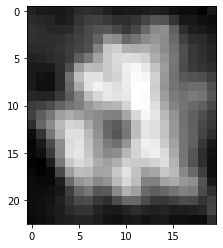

In [4]:
#Create pattern
rgb = it[163]['rgb']
rgb = np.moveaxis(rgb,0,-1)
lab_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)    
template = l_channel[765:788,775:795]
print(template.max(), template.min())
plt.imshow(template,cmap="gray")

In [11]:
data = it[163]
rgb = data['rgb']
nir = data['nir']
    
rgb = np.moveaxis(rgb,0,-1)
lab_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
    
w, h = template.shape[::-1]

res = cv2.matchTemplate(l_channel,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.7
loc = np.where( res >= threshold)
masked = rgb
for pt in zip(*loc[::-1]):
    masked = cv2.rectangle(masked, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
masked = masked.get()
l_channel = apply_brightness_contrast(cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY),32,92)
@interact(x=(0,rgb.shape[0],10),y=(0,rgb.shape[1],10),window_size=(100,400,5))
def plot_shape(x=1660, y=1020, window_size=360):
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    edges = cv2.Canny(l_channel[x:x+window_size,y:y+window_size],50,120)
    ax1.imshow(cv2.add(edges,l_channel[x:x+window_size,y:y+window_size]))
    ax2.imshow(cv2.add(np.moveaxis(np.stack([edges,0*edges,0*edges]),0,-1), rgb[x:x+window_size,y:y+window_size,:]), cmap="gray")

interactive(children=(IntSlider(value=1660, description='x', max=3698, step=10), IntSlider(value=1020, descrip…

(3698, 3337, 1) (3698, 3337)


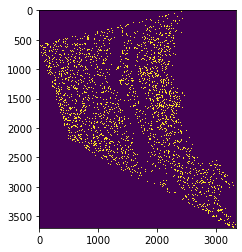

In [74]:
data = it[163]
rgb = data['rgb']
nir = data['nir']
    
rgb = np.moveaxis(rgb,0,-1)
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (3, 3), 0)
wide = cv2.Canny(blurred, 0, 120)

plt.imshow(wide)

In [1]:
data = it[163]
rgb = data['rgb']
nir = data['nir']
detector = cv2.SimpleBlobDetector()

rgb = np.moveaxis(rgb,0,-1)
lab_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)

l_channel = apply_brightness_contrast(cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY),32,82)

@interact(x=(0,rgb.shape[0],10),y=(0,rgb.shape[1],10),window_size=(100,400,5))
def plot_shape(x=1660, y=1020, window_size=360):
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12,12))
    fig.suptitle('Segmentation')
    fig.tight_layout()
    rgb_slice = rgb[x:x+window_size,y:y+window_size,:]
    l_slice = l_channel[x:x+window_size,y:y+window_size]
    keypoints = detector.detect(l_slice)
    #l_with_keypoints = cv2.drawKeypoints(l_slice, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #rgb_with_keypoints = cv2.drawKeypoints(rgb_slice, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #edges = cv2.Canny(l_channel[x:x+window_size,y:y+window_size],50,120)
    ax1.imshow(l_with_keypoints)
    ax2.imshow(rgb_with_keypoints)
 
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob


NameError: name 'it' is not defined

In [6]:
iterator = ForestIterator(rgb_path,shape_path)
iterator[0]

{'rgb': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'description': OrderedDict([('id_ob', 721),
              ('id_adres', 1420016057),
              ('adr_les', '14-20-2-13-359A  -    -'),
              ('pow', 39.53),
              ('oddz', '359A')])}